## Cross Validate Transfer Learning on Subset of CIFAR-10 Dataset.
Using 100 random images from each CIFAR-10 class, this notebook shows how to:
- Setup for the `retrain.cross_validate()` function:
    - Extract and cache features from a pre-trained model.
    - Define classes to combine.
    - Define classes to exclude.
    - Define a new Keras model.
    - Define optimizer.
- Use the `retrain.cross_validate()` function on the new model:
    - Train with the extracted features and definitions.
    - Balance classes with oversampling.
- Use the results CSVs to make ROC cruves.    
    
*Troubleshooting:*
If you have an error that wont go away, try manually deleting `./tmp/cifar10-subset-vgg16-bottlenecks.h5`.

In [1]:
import os
import shutil
import subprocess
import sys

import keras
from keras import backend as K
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.models import Model, Sequential

sys.path.append('../') # import modules from parent directory
import report
import retrain

Using TensorFlow backend.


#### Data

For the purposes of this demonstration, 100 images from each class in the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset are used. The images are saved as jpgs in labeled folders: 

    cifar10-subset
    ├── airplane
    ├── automobile
    ├── bird
    ├── cat
    ├── deer
    ├── dog
    ├── frog
    ├── horse
    ├── ship
    └── truck
    
The download process can take a little while but only happens the first time the code is run.

In [2]:
# download and save a subset of cifar10 if needed
if not os.path.exists('cifar10-subset'):
    print("Saving subset of cifar10 images as jpgs...\n")
    subprocess.call('python ./cifar10-as-jpgs.py', shell=True);

## Setup

Setup mainly involves creating variables that will ultimately be passed to the `cross_validate` function.

In [3]:
# setup paths
data_dir = './cifar10-subset/' # contains images in labeled folders
tmp_dir = './tmp/' 
bottleneck_file = tmp_dir + 'cifar10-subset-vgg16-bottlenecks.h5'

# remove any results files from previous runs
if os.path.exists(tmp_dir + 'results'):
    shutil.rmtree(tmp_dir + 'results')
os.makedirs(tmp_dir + 'results')

Display a summary of images in `data_dir`.

In [4]:
report.data_summary(data_dir)

Data Summary: ./cifar10-subset/ 

     Class      Count
---------------------
  airplane        100
automobile        100
      bird        100
       cat        100
      deer        100
       dog        100
      frog        100
     horse        100
      ship        100
     truck        100
---------------------
10 classes | 1000 images
median class size: 100.0 | mad: 0.0
mean class size: 100.0 | sd: 0.0



### Extract Features From a Pre-Trained Model

First select the base model to extract features from.
Here, a VGG16 model that has been pretrained on the ImageNet dataset is used.
If a bottleneck file doesn't already exist, the `retrain.create_bottlenecks()` function feeds the images in `data_dir` to the base model and saves the features and other data to a bottleneck file in the [HDF5](http://www.h5py.org/) format.
The first time this runs, it will take a while to generate features for every image.
Once a bottleneck file already exists, the function will do nothing.
 
See the docstring of `retrain.create_bottlenecks()` for more information.

In [5]:
base_model = retrain.load_base_model('VGG16', input_shape=(64, 64, 3))
retrain.create_bottlenecks(bottleneck_file, data_dir, base_model)

vgg16 base model with input shape (None, 64, 64, 3) loaded.

Generating bottleneck file... 
./tmp/cifar10-subset-vgg16-bottlenecks.h5 already exists.



### Combine Classes
The combine variable is a dictionary.
The classes in the tuple value will be combined into the one class defined by the corresponding key.
Here, all classes except for 'bird' are defined as belonging to two new classes.

In [6]:
combine = {'animals': ('cat', 'deer', 'dog', 'frog', 'horse'),
           'not-animals': ('airplane', 'automobile','ship', 'truck')}

### Exclude Classes
Here the class 'bird' is defined as excluded. The exclude variable is always a tuple.

In [7]:
exclude = ('bird', )

### Define New Model and Optimizer
The new model will be trained on features stored in the bottleneck file and will classify images into the two new classes that were defined.

In [8]:
K.clear_session() # reset TensorFlow graph each time this cell is run

model = Sequential(name='final_layers')
model.add(Dense(
    units=256, 
    activation='relu', 
    input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))
# want to classify the 2 new classes
model.add(Dense(units=2, activation='softmax'))

# define optimizer
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Cross Validate
Now the variables created during setup are passed to the `cross_validate` function.

### Balance Classes
The two new classes are balanced with `resample=1.0`, which tells the `cross_validate` function to oversample the training data for each fold, such that every class has the same number of training examples as the class with the most examples.

See the docstring of `retrain.cross_validate()` for more cross validation options.

In [9]:
retrain.cross_validate(
        model, optimizer, bottleneck_file, tmp_dir, data_dir, 
        combine=combine, exclude=exclude, resample=1.0, 
        base_model=base_model)

Loading ./tmp/cifar10-subset-vgg16-bottlenecks.h5...

Making animals class from ('cat', 'deer', 'dog', 'frog', 'horse')
Making not-animals class from ('airplane', 'automobile', 'ship', 'truck')
Updating class numbers...

Removing ('bird',) classes.
Updating class numbers...

Performing stratified 5-fold cross validation...
Fold 1/5
Oversampling to balance classes in training set.
Training set sizes will be at least 1.0 times max training set class size of 400.
Class number 1 training set size changed: 320 -> 400
Epoch 1/10
 - 0s - loss: 1.9281 - acc: 0.8163
Epoch 2/10
 - 0s - loss: 0.9096 - acc: 0.9075
Epoch 3/10
 - 0s - loss: 0.4721 - acc: 0.9475
Epoch 4/10
 - 0s - loss: 0.5691 - acc: 0.9438
Epoch 5/10
 - 0s - loss: 0.3316 - acc: 0.9700
Epoch 6/10
 - 0s - loss: 0.2750 - acc: 0.9688
Epoch 7/10
 - 0s - loss: 0.2878 - acc: 0.9637
Epoch 8/10
 - 0s - loss: 0.2344 - acc: 0.9700
Epoch 9/10
 - 0s - loss: 0.2004 - acc: 0.9763
Epoch 10/10
 - 0s - loss: 0.2588 - acc: 0.9738
Accuracy: 0.9389
F1 S

## Use Results CSVs

In addition to the console output, raw results from each fold are saved to CSVs. These CSVs can be used for further analysis in other platforms such as R, Excel, etc. Below is an example of how to use the CSVs to create [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curves. Due to defining two classes with combine and exclude, the fold CSVs contain results from binary classification.

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import interp
from sklearn.metrics import roc_curve, auc

Load the fold csvs into Pandas Dataframes and store in a list. Note that for this example no groups were used, so Pandas puts `NaN` in the `group_name` column.

In [11]:
folds = [pd.read_csv('./tmp/results/Fold 1.csv'),
         pd.read_csv('./tmp/results/Fold 2.csv'),
         pd.read_csv('./tmp/results/Fold 3.csv'),
         pd.read_csv('./tmp/results/Fold 4.csv'),
         pd.read_csv('./tmp/results/Fold 5.csv')]

print("Fold 1:")
display(folds[0].head())
print("\nFold 2:")
display(folds[1].head())
print("\netc...")

Fold 1:


,file_name,actual_class,group_name,score animals,score not-animals
0,airplane\13.jpg,not-animals,NaN,9.563612e-01,0.043639
1,airplane\15.jpg,not-animals,NaN,1.487116e-01,0.851288
2,airplane\16.jpg,not-animals,NaN,2.577585e-13,1.000000
3,airplane\18.jpg,not-animals,NaN,3.969940e-13,1.000000
4,airplane\29.jpg,not-animals,NaN,9.999831e-01,0.000017



Fold 2:


,file_name,actual_class,group_name,score animals,score not-animals
0,airplane\0.jpg,not-animals,NaN,2.598843e-01,7.401157e-01
1,airplane\1.jpg,not-animals,NaN,4.022067e-23,1.000000e+00
2,airplane\17.jpg,not-animals,NaN,1.000000e+00,1.664154e-12
3,airplane\39.jpg,not-animals,NaN,5.916685e-12,1.000000e+00
4,airplane\4.jpg,not-animals,NaN,6.970448e-18,1.000000e+00



etc...


The following function is based on this [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) from the scikit-learn website.

In [12]:
def roc_for_cv(splits, positive_class, score_column, split_prefix='Fold', title='Receiver Operating Characteristic'):
    """Plot ROC curves from binary classification results stored in list of Pandas Dataframe. 
    
    On one plot, plot an ROC curve for each Dataframe, an average ROC curve, and AUC for all curves.
    
    Arguments:
        splits: list of Pandas Dataframes with an 'actual_class' column and a scores column
        positive_class: string, name of the positive class 
        score_column: string, name of the scores column  
        split_prefix: prefix string for legend labels 
        title: plot title string
    """

    plt.rcParams['image.cmap'] = 'tab10'
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, split in enumerate(splits):
        y_score = split[score_column]
        y_true = pd.get_dummies(split['actual_class'])[positive_class]

        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC %s %d (AUC = %0.2f)' % (split_prefix, i + 1, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='0.66',
             label='Random Chance')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show() 

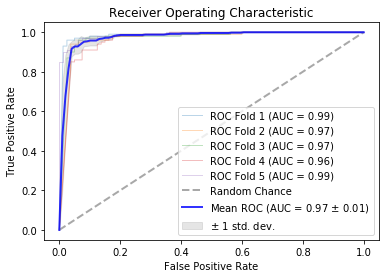

In [13]:
roc_for_cv(folds, positive_class='animals', score_column='score animals')